In [1]:
import qstock
import numpy as np
import pandas as pd

# 510880：红利ETF，代表价值
# 159915：创业板ETF，代表成长
# 513100：纳指ETF，代表外盘
# 518880：黄金ETF，代表商品
pool_list = ['510880', '159915', '513100', '518880']
start_date = '20130729'
# fqt:复权类型，0：不复权，1：前复权；2：后复权
data = qstock.get_price(pool_list, start=start_date, freq='d', fqt=2).sort_index()
name_list = data.columns.tolist()
data.head(10)

,红利ETF,创业板ETF,黄金ETF,纳指ETF
date,,,,
2013-07-29,1.808,1.124,2.626,1.015
2013-07-30,1.827,1.110,2.646,1.011
2013-07-31,1.832,1.122,2.657,1.013
2013-08-01,1.861,1.177,2.643,1.014
2013-08-02,1.856,1.169,2.578,1.023
2013-08-05,1.870,1.193,2.630,1.031
2013-08-06,1.879,1.196,2.591,1.030
2013-08-07,1.868,1.162,2.574,1.017
2013-08-08,1.862,1.171,2.586,1.018


In [2]:
from sklearn.linear_model import LinearRegression

# 计算强弱得分
def calculate_score(srs, N=25):
    if srs.shape[0] < N:
        return np.nan
    x = np.arange(1, N+1)
    y = srs.values / srs.values[0]
    lr = LinearRegression().fit(x.reshape(-1, 1), y)
    # 斜率
    slope = lr.coef_[0]
    # 决定系数R2
    r_squared = lr.score(x.reshape(-1, 1), y)
    # 得分
    score = 10000 * slope * r_squared
    return score

# 斜率计算长度
N = 25
# 计算每日涨跌幅和得分
for name in name_list:
    data['日收益率_'+name] = data[name] / data[name].shift(1) - 1.0
    data['得分_'+name] = data[name].rolling(N).apply(lambda x: calculate_score(x, N))
# 去掉缺失值
data = data.dropna()
data[['得分_'+v for v in name_list]].head(10)

,得分_红利ETF,得分_创业板ETF,得分_黄金ETF,得分_纳指ETF
date,,,,
2013-08-30,19.388578,7.634301,24.786073,-1.870733
2013-09-02,15.776847,6.395253,25.737782,-1.808997
2013-09-03,14.567841,5.127597,27.190043,-1.811506
2013-09-04,12.954650,4.009073,30.523393,-1.827347
2013-09-05,12.195159,7.405885,30.715504,-1.355849
2013-09-06,11.455272,10.956240,23.902942,-0.750268
2013-09-09,12.663860,17.407530,22.132165,-0.066458
2013-09-10,15.583046,25.238913,17.370603,0.002855
2013-09-11,18.157391,22.248010,11.106987,0.111100


In [3]:
# 取出每日涨幅最大的证券
data['信号'] = data[['得分_'+v for v in name_list]].idxmax(axis=1).str.replace('得分_', '')
# 今日的涨幅由昨日的持仓产生
data['信号'] = data['信号'].shift(1)
data = data.dropna()
data['轮动策略日收益率'] = data.apply(lambda x: x['日收益率_'+x['信号']], axis=1) 
# 第一天尾盘交易，当日涨幅不纳入
data.loc[data.index[0],'轮动策略日收益率'] = 0.0
data['轮动策略净值'] = (1.0 + data['轮动策略日收益率']).cumprod()
data[['得分_'+v for v in name_list]+['信号','轮动策略日收益率','轮动策略净值']].head(10)

,得分_红利ETF,得分_创业板ETF,得分_黄金ETF,得分_纳指ETF,信号,轮动策略日收益率,轮动策略净值
date,,,,,,,
2013-09-02,15.776847,6.395253,25.737782,-1.808997,黄金ETF,0.000000,1.000000
2013-09-03,14.567841,5.127597,27.190043,-1.811506,黄金ETF,-0.001807,0.998193
2013-09-04,12.954650,4.009073,30.523393,-1.827347,黄金ETF,0.009051,1.007228
2013-09-05,12.195159,7.405885,30.715504,-1.355849,黄金ETF,-0.012917,0.994218
2013-09-06,11.455272,10.956240,23.902942,-0.750268,黄金ETF,-0.009451,0.984821
2013-09-09,12.663860,17.407530,22.132165,-0.066458,黄金ETF,0.011376,0.996025
2013-09-10,15.583046,25.238913,17.370603,0.002855,黄金ETF,-0.005080,0.990965
2013-09-11,18.157391,22.248010,11.106987,0.111100,创业板ETF,-0.033762,0.957508
2013-09-12,20.730446,21.161244,4.427721,0.530470,创业板ETF,0.004160,0.961491


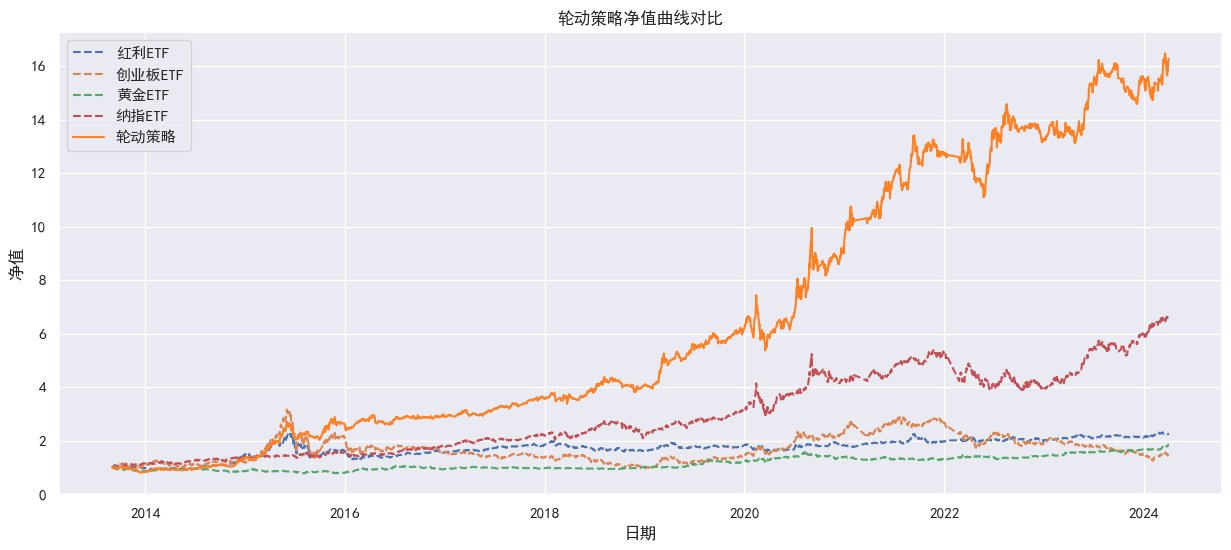

In [4]:
import matplotlib.pyplot as plt

# 显示中文设置
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

# 绘制净值曲线图
fig, ax = plt.subplots(figsize=(15, 6))
ax.set_xlabel('日期')
ax.set_ylabel('净值')
for name in name_list+['轮动策略']:
    if name in name_list:
        data[name+'净值'] = data[name]/data[name].iloc[0]
        ax.plot(data[name+'净值'].index, data[name+'净值'].values, linestyle='--')
    else:
        ax.plot(data[name+'净值'].index, data[name+'净值'].values, linestyle='-', color='#FF8124')

# 显示图例和标题
ax.legend(name_list+['轮动策略'])
ax.set_title('轮动策略净值曲线对比')

plt.show()

                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2013-09-03   2013-09-03
End Period          2023-07-28   2023-07-28
Risk-Free Rate      0.0%         0.0%
Time in Market      98.0%        99.0%

Cumulative Return   460.28%      1,482.79%
CAGR﹪              12.76%       21.23%

Sharpe              0.96         1.34
Prob. Sharpe Ratio  99.76%       100.0%
Sortino             1.34         1.97
Sortino/√2          0.95         1.39
Omega               1.29         1.29

Max Drawdown        -28.57%      -27.64%
Longest DD Days     569          315

Gain/Pain Ratio     0.19         0.29
Gain/Pain (1M)      1.21         2.02

Payoff Ratio        0.97         1.0
Profit Factor       1.19         1.29
Common Sense Ratio  1.34         1.62
CPC Index           0.62         0.7
Tail Ratio          1.12         1.26
Outlier Win Ratio   4.41         3.83
Outlier Loss Ratio  4.3          4.07

MTD                 3.09%        3.09%
3M          

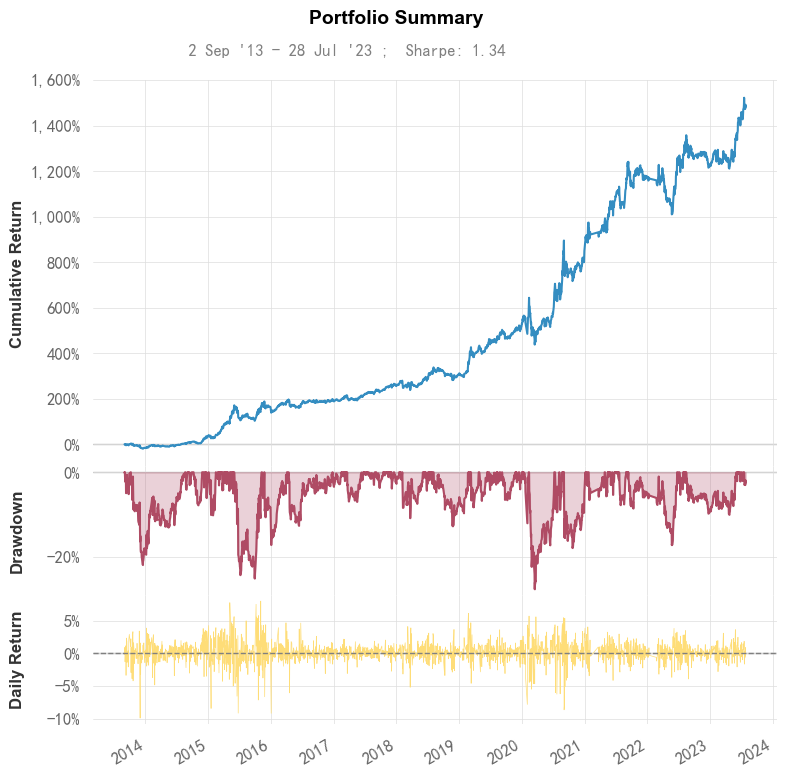

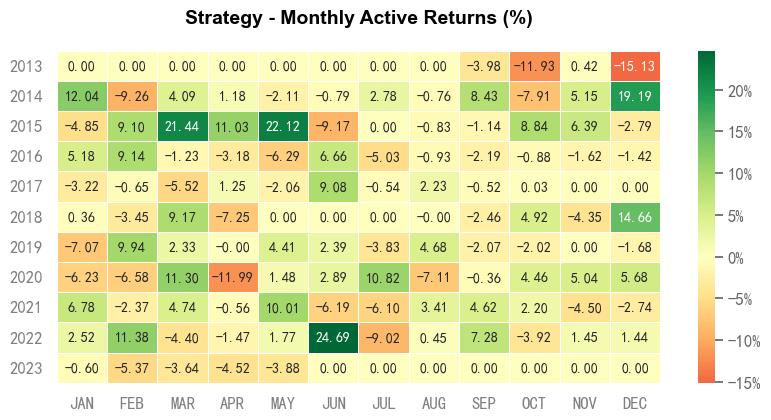

In [126]:
import quantstats as qstat

#将完整回测报告存为HTML文件
qstat.reports.html(data['轮动策略净值'], benchmark=data['纳指ETF净值'],
                  title='轮动策略回测报告 by 公众号【量化君也】',
                  download_filename='轮动策略回测报告.html') 
#输出基本回测报告信息
qstat.reports.basic(data['轮动策略净值'], benchmark=data['纳指ETF净值']) 